In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pertpy as pt
import scanpy as sc
import pandas as pd
import seaborn as sb

plt.rcParams["figure.figsize"] = (7, 7)
import numpy as np

sc.settings.verbosity = 3

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors

#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [7]:
## Define color palette
pal = sb.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [8]:
import os,sys

figdir = './'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir

In [9]:
%%R -i design_palette_df -i figdir
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [10]:
from adjustText import adjust_text
import matplotlib.patheffects as pe

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [11]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)

# Read in adata and ensure proper formating/columns-- READ IN OL data

In [12]:
adata= sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/scVI_mdata_AS_working.h5ad')
adata

AnnData object with n_obs × n_vars = 39306 × 26647
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'Cycling cells', 'Cycling_cells', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DCs

## Start MILO analysis

In [13]:
## Initialize object for Milo analysis
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 39306 × 26647
  2 modalities
    rna:	39306 x 26647
      obs:	'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'Cycling cells', 'Cycling_cells', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DCs', 'NKT cells', 'T cells', 'B cells', 'Neutrophils', 'Neurons', 'OPCs', 'COPs', 'MOL', 'Astrocytes', 'Pericytes', 'VSMCs', 'VLMCs', 'VECV', 'scVI_leiden_0.5', 'scVI_leiden_1', 'cluster_annotation', 'cell_leiden_annotated', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_genes', 'leiden_AS_r0.5', 'leiden_AS_r1', 'leiden_AS_r1.5', 'common_innate_immunity_human', 'IRAS1', 'IRAS2', 'leiden_1_annotation', 'cluster_annotation_lettered'
      var:	'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'hb', 'ribo', 'mt', 'log1p_mean_counts', 'log1p_total_counts', 'mito'
      uns:	'Cycling_cells_colors', 'cell_leiden_annotated_colors', 'cluster_annotation_colors', 'cluster_annotation_lettered_colors', 'dendrogram_cell_type_eval', 'dendrogram_cluster_annotation', 'dendrogram_leiden_AS_r1', 'dendrogram_scVI_leiden_1', 'dendrogram_type_broad', 'leiden_1_annotation_colors', 'leiden_AS_r0.5', 'leiden_AS_r0.5_colors', 'leiden_AS_r1', 'leiden_AS_r1.5', 'leiden_AS_r1.5_colors', 'leiden_AS_r1_colors', 'lesion_type_colors', 'neighbors', 'phase_colors', 'rank_genes_annotated', 'rank_genes_cluster_annotation', 'rank_genes_leiden_1', 'scVI_leiden_1_colors', 'type_broad_colors', 'type_fine_colors', 'umap'
      obsm:	'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
      layers:	'counts', 'log1p_norm'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [14]:
sc.pp.neighbors(mdata["rna"], use_rep="X_scVI", n_neighbors=100)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:57)


In [15]:
milo.make_nhoods(mdata["rna"], prop=0.1)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8798133  0.88135904 0.8244446  ... 1.167892   1.0400251  1.0076938 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"] == 1, "nhood_kth_distance"] = k_distances


In [16]:
mdata["rna"][mdata["rna"].obs["nhood_ixs_refined"] != 0].obs[["nhood_ixs_refined", "nhood_kth_distance"]]

,nhood_ixs_refined,nhood_kth_distance
Ind98-Sample2:AAACGCTAGCGTATGG-1,1,0.879813
Ind98-Sample2:AAGCCATCAGTTGTTG-1,1,0.881359
Ind98-Sample2:ACAACCAAGAGATGCC-1,1,0.824445
Ind98-Sample2:ACCCAAATCTTTGCAT-1,1,0.799493
Ind98-Sample2:ACGATCAGTTCTTGCC-1,1,0.814530
...,...,...
Ind102-Sample4:GCTTGGGTCATATGGC-1,1,0.980311
Ind102-Sample4:TCATCCGGTTGATGTC-1,1,1.302162
Ind102-Sample4:TGCAGGCTCCGTGTGG-1,1,1.167892
Ind102-Sample4:TTCTTGATCGTTGTAG-1,1,1.040025


Text(0, 0.5, '# nhoods')

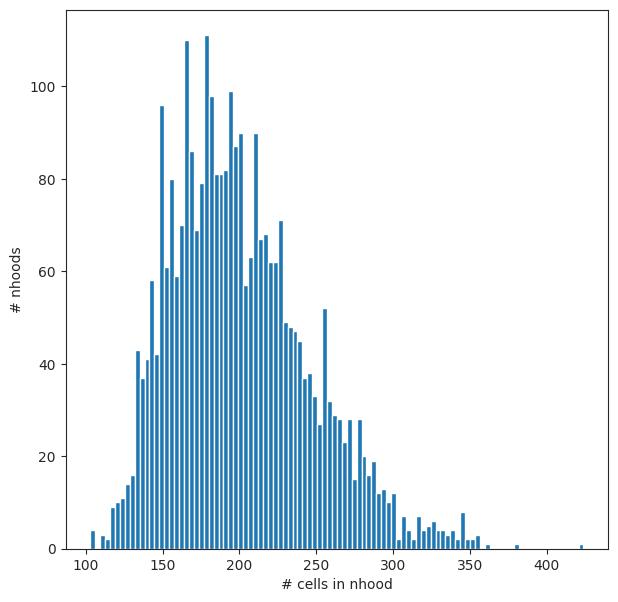

In [17]:
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("# cells in nhood")
plt.ylabel("# nhoods")

In [18]:
np.median(nhood_size)

194.0

In [19]:
mdata = milo.count_nhoods(mdata, sample_col="sample_id_anon")

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


# Set up comparison

In [20]:
# Update the 'treatment_meta' column based on the mapping
mdata["rna"].obs['status'] = mdata["rna"].obs['lesion_type']

In [21]:
# Convert the 'status' column to categorical dtype first
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].astype("category")

# Now reorder the categories as you were trying to do
mdata["rna"].obs["status"] = mdata["rna"].obs["status"].cat.reorder_categories([
    "WM", "NAWM", "AL", "CAL", "CIL", "RL"], ordered=True)

In [22]:
milo.da_nhoods(
    mdata, design="~status", model_contrasts="statusRL-statusWM"
)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:691: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:692: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = w[keep_nhoods][o]


Text(0, 0.5, 'Mean # cells per sample in nhood')

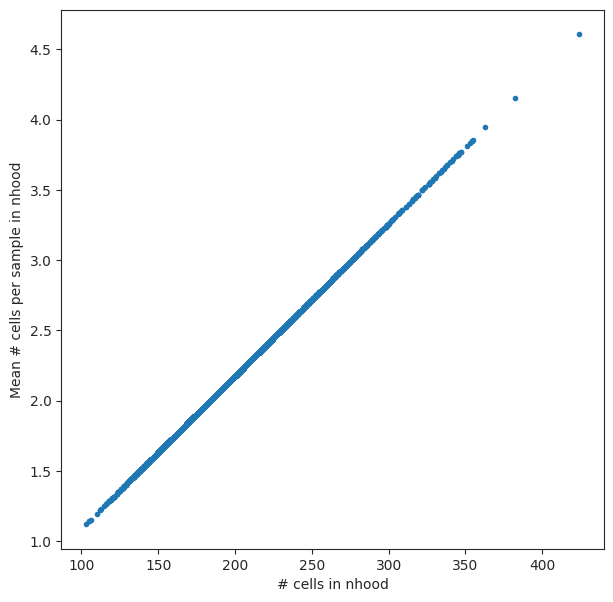

In [23]:
mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

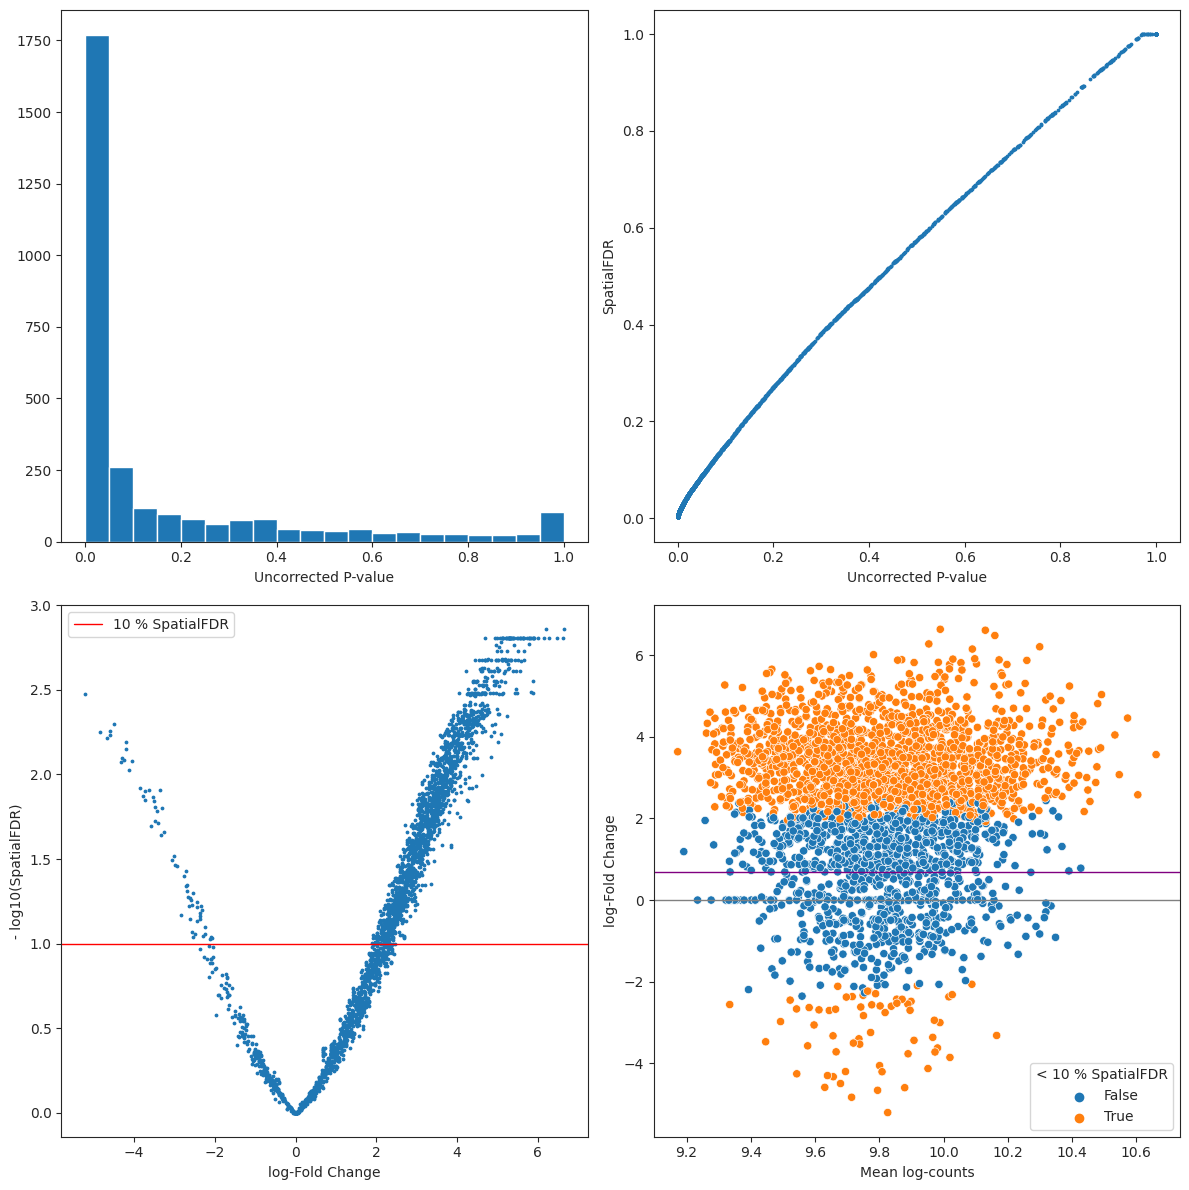

In [24]:
def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sb.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

# Visualize results on embedding

In [25]:
milo.build_nhood_graph(mdata)

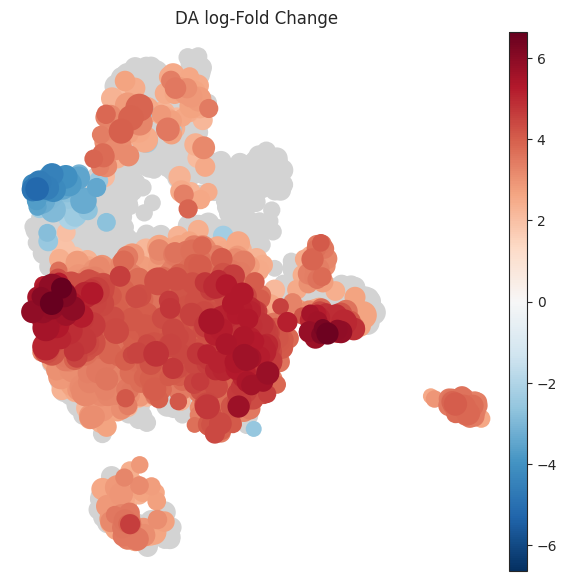

In [26]:
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.1,  ## SpatialFDR level (0.1%)
    min_size=5,  ## Size of smallest dot
    plot_edges=False,
    save='_RL_all_AST.png'
)

# Visualize by cell type

In [27]:
sample_map = {
    'Astro_A': 'Ast_A',
    'Astro_B': 'Ast_B',
    'Ciliated': 'Ciliated',
    'Astro_E': 'Ast_E',
    'Astro_F': 'Ast_F',
    'Astro_D': 'Ast_D',
    'Mixed': 'Ast_mixed',
    'Astro_C': 'Ast_C'
}

# Update the 'treatment_meta' column based on the mapping
mdata["rna"].obs['cell_type'] = mdata["rna"].obs['cluster_annotation'].map(sample_map)

In [28]:
milo.annotate_nhoods(mdata, anno_col="cell_type")

Text(0.5, 0, 'OL celltype fraction')

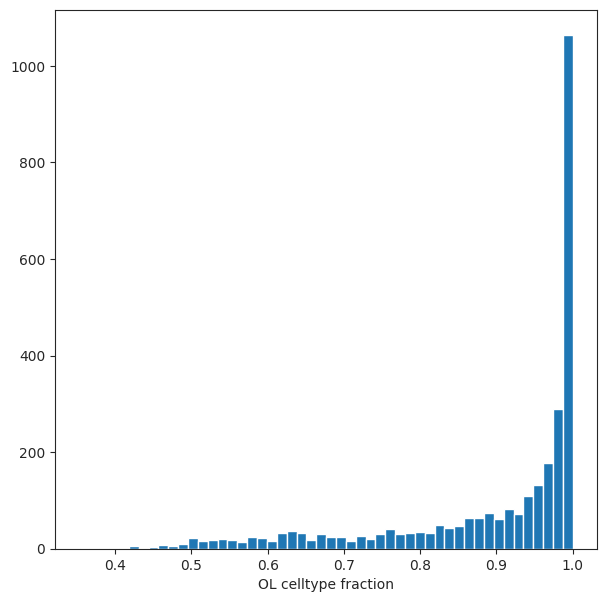

In [29]:
plt.hist(mdata["milo"].var["nhood_annotation_frac"], bins=50)
plt.xlabel("OL celltype fraction")

In [30]:
# Check current categories of 'nhood_annotation'
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories

# Add new category 'Mixed' if it doesn't already exist
if "Mixed" not in current_categories:
    mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")

# Now assign "Mixed" to rows where 'nhood_annotation_frac' < 0.6
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/pertpy/tools/_milo.py:908: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nhood_adata.obs[[anno_col, "logFC"]].groupby(anno_col).median().sort_values("logFC", ascending=True).index
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/edgeR/lib/python3.11/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is 

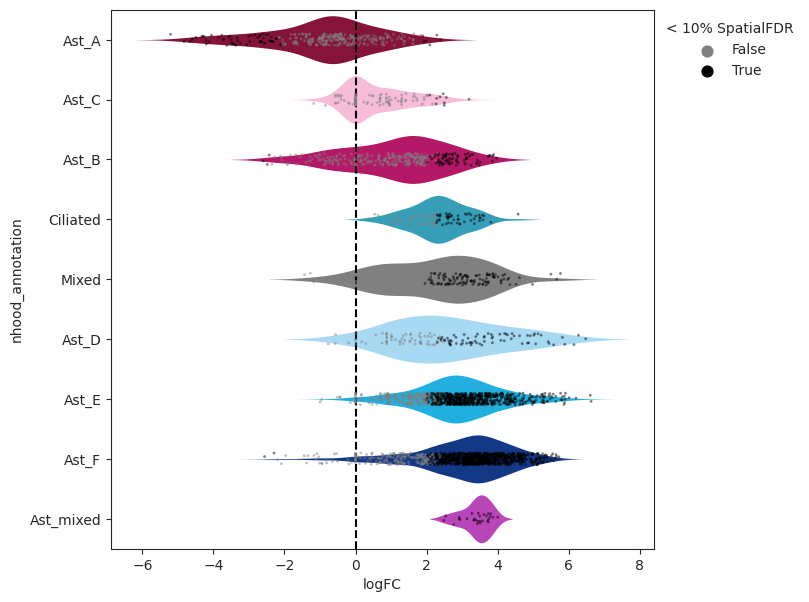

In [31]:
# Define your cluster colors dictionary
cluster_color = {
    'Ast_A': '#990033',
    'Ast_B': '#cc0066',
    'Ast_C': '#ffb3db',
    'Ast_D': '#9bddff',
    'Ast_E': '#00bfff',
    'Ast_F': '#003399',
    'Ciliated': '#21abcd',
    'Ast_mixed': '#cc33cc',
    'Mixed': '#808080'  # Assign a color for 'Mixed' category
}

# Ensure all categories including 'Mixed' are in the nhood_annotation
current_categories = mdata["milo"].var["nhood_annotation"].cat.categories
desired_categories = list(cluster_color.keys())

for cat in desired_categories:
    if cat not in current_categories:
        mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories(cat)

# Now plot with custom colors
milo.plot_da_beeswarm(mdata, alpha=0.1, 
                      palette=cluster_color,
                     save='_RL_AST.png')

In [32]:
nh_df = mdata["milo"].var.copy()
nh_df[:5]

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR,Sig,Nhood_size,nhood_annotation,nhood_annotation_frac
0,Ind98-Sample2:AAACGCTAGCGTATGG-1,0.879813,-3.720524,9.665588,8.660489,0.003596,0.013627,0.014193,True,158.0,Ast_A,0.968354
1,Ind98-Sample2:AAGCCATCAGTTGTTG-1,0.881359,-2.978661,9.492655,6.142369,0.014055,0.033355,0.034509,True,157.0,Ast_A,0.993631
2,Ind98-Sample2:ACAACCAAGAGATGCC-1,0.824445,-4.599336,9.879068,11.944705,0.000680,0.005579,0.005808,True,242.0,Ast_A,0.991736
3,Ind98-Sample2:ACCCAAATCTTTGCAT-1,0.799493,-4.663435,9.794745,11.807267,0.000752,0.005866,0.006096,True,236.0,Ast_A,1.000000
4,Ind98-Sample2:ACGATCAGTTCTTGCC-1,0.814530,-4.058068,9.800931,10.571835,0.001367,0.008046,0.008356,True,234.0,Ast_A,0.987179


In [33]:
%%R -i nh_df
head(nh_df)

                        index_cell kth_distance     logFC   logCPM         F
0 Ind98-Sample2:AAACGCTAGCGTATGG-1    0.8798133 -3.720524 9.665588  8.660489
1 Ind98-Sample2:AAGCCATCAGTTGTTG-1    0.8813590 -2.978661 9.492655  6.142369
2 Ind98-Sample2:ACAACCAAGAGATGCC-1    0.8244446 -4.599336 9.879068 11.944705
3 Ind98-Sample2:ACCCAAATCTTTGCAT-1    0.7994933 -4.663435 9.794745 11.807267
4 Ind98-Sample2:ACGATCAGTTCTTGCC-1    0.8145298 -4.058068 9.800931 10.571835
5 Ind98-Sample2:ATCCTATAGTATGAGT-1    1.0252126 -1.687144 9.676307  2.639444
        PValue         FDR  SpatialFDR   Sig Nhood_size nhood_annotation
0 0.0035959350 0.013626575 0.014193026  TRUE        158            Ast_A
1 0.0140551712 0.033354644 0.034508803  TRUE        157            Ast_A
2 0.0006795834 0.005579117 0.005808145  TRUE        242            Ast_A
3 0.0007523291 0.005866212 0.006095644  TRUE        236            Ast_A
4 0.0013669225 0.008046081 0.008355594  TRUE        234            Ast_A
5 0.1055002660 0.154342

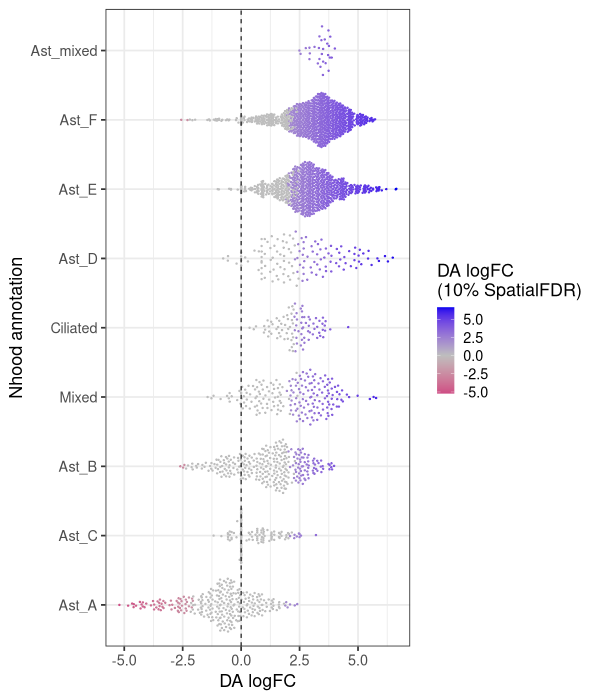

In [34]:
%%R -h 700 -w 600

#figdir <- './sysVI_mm_OL_figures/'

nh_df %>%
  # filter(nhood_annotation_frac > 0.5) %>%
  mutate(signif = ifelse(SpatialFDR < 0.1, logFC, 0)) %>%
  group_by(nhood_annotation) %>%
  mutate(mean_lfc_val = ifelse(!is.na(signif), logFC, 0)) %>%
  mutate(mean_lfc = mean(mean_lfc_val)) %>%
  ungroup() %>%
  arrange(mean_lfc) %>%
  mutate(nhood_annotation = factor(nhood_annotation, levels = unique(nhood_annotation))) %>%
  ggplot(aes(nhood_annotation, logFC, color = signif)) + 
  ggbeeswarm::geom_quasirandom(size = 0.5) +
  coord_flip() +
  scale_color_gradient2(high = 'blue2', mid = 'grey', low = 'deeppink3', name = 'DA logFC\n(10% SpatialFDR)') +
  theme_bw(base_size = 18) +
  geom_hline(yintercept = 0, linetype = 2) +
  xlab('Nhood annotation') + 
  ylab('DA logFC')
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.png'), width = 10, height = 12) +
  #ggsave(paste0(figdir, 'beeswarm_fine_anno.pdf'), width = 10, height = 12)

In [35]:
nh_df.to_csv('nh_df_RL_AST.csv', index=True)  # index=True to include row names